In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
"""
sequence data-data tht comes in a particular order
"""
#df_1 = pd.read_csv('apple_stock.csv', parse_dates=True, index_col=[0])

'\nsequence data-data tht comes in a particular order\n'

In [51]:
#df_1.head()

In [52]:
df_1 = pd.read_csv('data/apple_2012_1_1-2019_12_17.csv', parse_dates=True, index_col=[0])

In [53]:
apple_training = df_1['2012-1-1':'2018-1-1']

In [54]:
apple_training.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.737655
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.879071
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013705
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,12.993064


In [55]:
apple_training_processed = apple_training['Close']

In [56]:
df = pd.DataFrame(apple_training_processed)

In [57]:
print(df.shape)
print(len(df) *0.2) 

(1509, 1)
301.8


In [58]:
test_percent = 0.2 
len(df) * test_percent
test_point = np.round(len(df) * test_percent)
test_ind = int(len(df) - test_point)
train = df.iloc[:test_ind]
test = df.iloc[test_ind:] #test_ind point and go to end
train.shape, test.shape

((1207, 1), (302, 1))

In [59]:
#nned to scale label b/c it's being fed back into neuron
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit_transform(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [60]:
#apple_training_scaled

In [61]:
#apple_training_scaled

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [63]:
#model = Sequential()

In [64]:
"""
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
"""


'\nmodel.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))\nmodel.add(Dropout(0.2))\n\nmodel.add(LSTM(units=50, return_sequences=True))\nmodel.add(Dropout(0.2))\n\nmodel.add(LSTM(units=50, return_sequences=True))\nmodel.add(Dropout(0.2))\n\nmodel.add(LSTM(units=50))\nmodel.add(Dropout(0.2))\n\nmodel.add(Dense(units = 1))\n'

In [65]:
#model.fit(features_set, labels, epochs = 100, batch_size = 32)

In [66]:
#print(len(apple_training_processed) *0.2) # 1509-1,208 #1,208
#apple_testing_processed = test.copy()

In [67]:
#apple_total = pd.concat((train['Open'], test['Open']), axis=0)

In [68]:
#test_inputs = apple_total[len(apple_total) - len(test) - 60:].values

In [69]:
# test_inputs = test_inputs.reshape(-1,1)
# test_inputs = scaler.transform(test_inputs)


In [70]:
# test_features = []
# for i in range(60, 302):
#     test_features.append(test_inputs[i-60:i, 0])


In [71]:
# test_features = np.array(test_features)
# test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))


In [72]:
#predictions = model.predict(test_features)

In [73]:
# plt.figure(figsize=(10,6))
# plt.plot(apple_testing_processed, color='blue', label='Actual Apple Stock Price')
# plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
# plt.title('Apple Stock Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Apple Stock Price')
# plt.legend()
# plt.show()

In [74]:
# model.add(LSTM(units = 50, return_sequences = True, input_shape = (length, n_features)))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# model.add(Dense(units = 1))

# model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [75]:
# model.add(LSTM(units = 50, return_sequences = True, input_shape = (length, n_features)))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# model.add(Dense(units = 1))

# model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [76]:
#df = df['Close']

In [77]:
#df.head()

In [78]:
#df = pd.DataFrame(df)

In [79]:
#df.head()

In [80]:
#df

In [81]:
#df.shape

In [82]:
#df.info()

In [83]:
# df.plot(figsize=(12,8));
# plt.title('Closing Price History');
# plt.ylabel('Closnig Price USD ($)')

## Train Test Split

## Normalize Data

## Create TimeSeriesGenerator

In [84]:
"""
take train batches and tansform them into sequences


"""
from keras.preprocessing.sequence import TimeseriesGenerator

In [85]:
"""
-take training data and create batches for training purposes off of it
-it generates batches for sequence data

-length-lenght of output sequences. Number of time steps.
-batch_size -number of time series sample in each batch

-how many sequences per batch?

forecasting technique-predcit a timestep ahead.  Then incorporate our prediction into the next sequence we predcit off of
    You're forecasting on forecasts


length of batch needs to be less than lenght of test set
can't feed in a batch of 151 days and get a predicton on 152nd day
batches need to be shortd than 151

We'll pas in 1 at a time
test=400
create for training data
"""
length = 60   #length of output sequences in the number of timestep. # of timeseries samples in each batch
batch_size = 32 #how many time series samples are we returning in each batch

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)#batch_size-1 array for X and 1 value for y
                                                                                         #if this were 2, you'd get 2 sets for X and 2 for y

In [86]:
len(scaled_train)

1207

In [87]:
"""
generator object is going to geneate batches for us
ie. if length =2, then 1207-2 = 1205
ie, if length=60, thrn 1207-60=1147
"""
len(generator)

36

## Create the Model

In [88]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [89]:

n_features = 1

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(length, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
__________

In [91]:
from keras.callbacks import EarlyStopping

In [92]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [93]:
len(scaled_test), length

(302, 60)

In [94]:
#create generator for scaled_test/validation set
#lenght of batches must be at lest 1 shorter than scaled_test data
#length = 300

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [95]:
model.fit_generator(generator, epochs=50, validation_data=validation_generator,callbacks=[early_stop] ) #,callbacks=[early_stop]

Epoch 1/50
36/36 [==============================] - 16s 441ms/step - loss: 0.0595 - val_loss: 0.0822
Epoch 2/50
36/36 [==============================] - 10s 269ms/step - loss: 0.0187 - val_loss: 0.0646
Epoch 3/50
36/36 [==============================] - 11s 301ms/step - loss: 0.0076 - val_loss: 0.0139
Epoch 4/50
36/36 [==============================] - 9s 254ms/step - loss: 0.0063 - val_loss: 0.0386
Epoch 5/50
36/36 [==============================] - 8s 229ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 6/50
36/36 [==============================] - 10s 270ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 7/50
36/36 [==============================] - 10s 269ms/step - loss: 0.0048 - val_loss: 0.0086
Epoch 8/50
36/36 [==============================] - 9s 239ms/step - loss: 0.0046 - val_loss: 0.0321


In [96]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

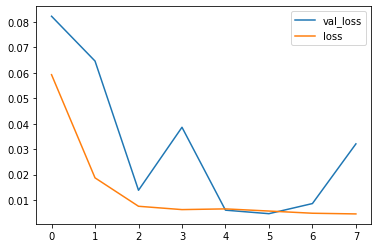

In [97]:
"""

"""
losses.plot()

### Evaluate on Test Data
Forecast predictions for the test data range(-- days of the entire dataset).<br>
Final result will be DataFrame with 2 columns, true test values and the predictions.<br>

In [98]:
"""
evaluate test predictions
"""

test_predictions = []

#last 60 days of train set to predcit 1 day in the future, which is 1st point in test set
#ie 24, would be last 24 days of training data. 24 days to predict 1 day into the future
first_eval_batch = scaled_train[-length:] #should be in last batch if training data
#change 1
# 1 time series per batch(batch_size), length, n_features=1
current_batch = first_eval_batch.reshape((1,length, n_features)) #reshape to correct format. 1 item per batch

for i in range(len(test)): #only forecasting on test set
    #get hte predcition 1 timestamp ahead.
    current_pred = model.predict(current_batch)[0] #to be current prediction
    
    test_predictions.append(current_pred) #take current_pred and append to list
    #in order to keep predicintg into future need to move current batch forward 1 timestep
    #gets rid of 1st item and replaces it with current prediction all the way to the very end
    #drops 1st value in current_batch
    #append curent predcition value. Moves current_batch 1 value into the future
    #true forecast is predciting off predictions
    #1-grab everythin but index 0
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)


In [ ]:
#current_batch.shape

In [99]:
true_predictions = scaler.inverse_transform(test_predictions)

In [103]:
test['LSTM Predictions'] = true_predictions

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
test.head(25)

,Close,Predictions,LSTM Predictions
Date,,,
2016-10-19,29.280001,27.753408,27.753408
2016-10-20,29.264999,27.809767,27.809767
2016-10-21,29.150000,27.825316,27.825316
2016-10-24,29.412500,27.801525,27.801525
2016-10-25,29.562500,27.745161,27.745161
2016-10-26,28.897499,27.664543,27.664543
2016-10-27,28.620001,27.567523,27.567523
2016-10-28,28.430000,27.460530,27.460530
2016-10-31,28.385000,27.348342,27.348342


<AxesSubplot:xlabel='Date'>

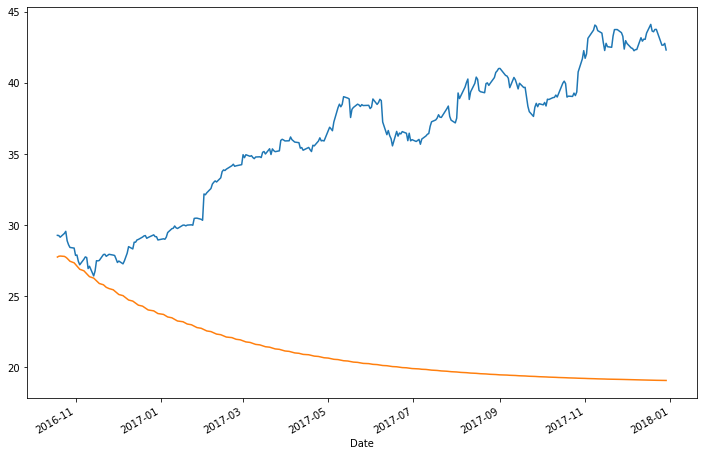

In [106]:
test['Close'].plot(figsize=(12,8))
test['LSTM Predictions'].plot()

#### Calculate RMSE

In [107]:
from sklearn.metrics import mean_squared_error

In [108]:
#how accurate model predicts reponse
rmse = np.sqrt(mean_squared_error(test['Close'],test['Predictions']))
rmse

16.39005850386396

## Forecast into Unknown Future

In [110]:

full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)


In [111]:
length = 201
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

In [112]:
n_features = 1


n_features = 1

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(length, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [113]:
model.fit_generator(generator, epochs=500, validation_data=validation_generator)

Epoch 1/100
31/41 [=====================>........] - ETA: 8s - loss: 0.0451

KeyboardInterrupt: 

In [ ]:
forecast = []
periods = 10 #forecasting off predeiciotns, adding in more predictions
             #forecast length should be the same as test length
            #should equal intial batch length

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0] #to be current prediction
    
    forecast.append(current_pred) #take current_pred and append to list
    #in order to keep predicintg into future need to move current batch forward 1 timestep
    #gets rid of 1st item and replaces it with current prediction all the way to the very end
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)


In [ ]:
# #inverse scale 
# forecast = scaler.inverse_transform(forecast)

In [ ]:
# df

In [ ]:
# #going into 2020
# forecast

In [ ]:
#len(forecast)

In [ ]:
# #build forecast index
# #forecasting off predictions
# #period should be equal to intial batch ength
# forecast_index = pd.date_range(start='2020-01-01',periods=periods, freq='B')

In [ ]:
#forecast_index

In [ ]:
#forecast_df = pd.DataFrame(data=forecast,index=forecast_index, columns=['Forecast'])

In [ ]:
#forecast_df.plot()

In [ ]:
# ax=df.plot()
# forecast_df.plot(ax=ax)

In [ ]:
# ax=df.plot()
# forecast_df.plot(ax=ax)
# plt.xlim('2020-01-01','2020-04-01')

In [ ]:
import pandas_datareader.data as web

from datetime import date

In [ ]:
#df = pd.read_csv('data/air_passengers.csv', parse_dates=True, index_col=[0])

In [ ]:
#df.head()

In [ ]:
# #Get the stock quote
# start_date = '2012-01-01'
# end_date = '2019-12-17'
# df = web.DataReader('AAPL', data_source='yahoo', start=start_date, end=end_date) 
# #Show the data 
# df.tail()

In [ ]:
#df.to_csv('data/apple_2012_1_1-2019_12_17.csv')

In [ ]:
df_1 = pd.read_csv('data/apple_2012_1_1-2019_12_17.csv', parse_dates=True, index_col=[0])

In [ ]:
df_1.shape

In [ ]:
#test_percent = 0.2 
#len(df) * test_percent
#test_point = np.round(len(df) * test_percent)
#test_ind = int(len(df) - test_point)
#train = df.iloc[:test_ind]
#test = df.iloc[test_ind:]
#train.shape, test.shape

In [ ]:
df = df_1['Close']

In [ ]:
df = pd.DataFrame(df)
df.head()

In [ ]:
df.shape

In [ ]:
# train=df[:132]
# test=df[132:]
# scaler=MinMaxScaler()
# scaled_train=scaler.fit_transform(train)
# scaled_test=scaler.transform(test)
test_percent = 0.2 
len(df) * test_percent
test_point = np.round(len(df) * test_percent)
test_ind = int(len(df) - test_point)
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.shape, test.shape

In [ ]:
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)
scaled_train.shape, scaled_test.shape

In [ ]:
length=60    #use last 12 months data to predict the next month data.
n_features=1  #we have 1 feature
batch_size=32

In [ ]:
#TimeSeries generator that would give us the data in the 3D format
# format needs to be (#batch_size,#inputs,#features), so here this would be (1,12,1)
generator=TimeseriesGenerator(scaled_train,
                                     scaled_train,
                                     length= length, 
                                    batch_size=batch_size)                                     

In [ ]:
len(train_generator)

In [ ]:
scaled_train.shape

In [ ]:
model=Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (length, n_features)))
#model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
#model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
#model.add(Dropout(0.2))

model.add(LSTM(units = 50))
#model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
model.compile(optimizer='adam',loss='mse')
model.summary()

In [ ]:
##model.fit_generator(generator, epochs=1, validation_data=validation_generator,callbacks=[early_stop] ) #,callbacks=[early_stop]
model.fit_generator(generator,epochs=50)

In [ ]:
my_loss= model.history.history['loss']
plt.plot(range(len(my_loss)),my_loss);

In [ ]:
test_predictions = []

#last 60 days of train set to predcit 1 day in the future, which is 1st point in test set
#ie 24, would be last 24 days of training data. 24 days to predict 1 day into the future
first_eval_batch = scaled_train[-n_input:] #should be in last batch if training data
#change 1
# 1 time series per batch(batch_size), length, n_features=1
current_batch = first_eval_batch.reshape((1,n_input,n_features)) #reshape to correct format. 1 item per batch

for i in range(len(test)): #only forecasting on test set
    #get hte predcition 1 timestamp ahead.
    current_pred = model.predict(current_batch)[0] #to be current prediction
    
    test_predictions.append(current_pred) #take current_pred and append to list
    #in order to keep predicintg into future need to move current batch forward 1 timestep
    #gets rid of 1st item and replaces it with current prediction all the way to the very end
    #drops 1st value in current_batch
    #append curent predcition value. Moves current_batch 1 value into the future
    #true forecast is predciting off predictions
    #1-grab everythin but index 0
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)


"""
test_predictions = []
#Select last n_input values from the train data
first_eval_batch = scaled_train[-n_input:]
#reshape the data into LSTM required (#batch,#timesteps,#features)
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
# get prediction, grab the exact number using the [0]
  pred = model.predict(current_batch)[0]
# Add this prediction to the list
  test_predictions.append(pred)
# The most critical part, update the (#batch,#timesteps,#features
# using np.append(
# current_batch[:        ,1:   ,:] ---------> read this as
# current_batch[no_change,1:end,no_change]
# (Do note the second part has the timesteps)
# [[pred]] need the double brackets as current_batch is a 3D array
# axis=1, remember we need to add to the second part i.e. 1st axis
  current_batch = np.append(current_batch[:,1:,:],
                          [[current_pred]],
                          axis=1)
"""                          

In [ ]:
test_predictions

In [ ]:
actual_predictions = scaler.inverse_transform(test_predictions)
actual_predictions

In [ ]:
test['Predictions'] = actual_predictions
#test.plot(figsize=(12,8));

In [ ]:
test.tail(20)

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
#how accurate model predicts reponse
rmse = np.sqrt(mean_squared_error(test['Predictions'],test['Close'],))
rmse

In [ ]:
"""
test_percent = 0.2 
len(df) * test_percent
test_point = np.round(len(df) * test_percent)
test_ind = int(len(df) - test_point)
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.shape, test.shape

"""
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(test['Close'])
plt.plot(test['Predictions'])
#plt.plot(test['Close'], test['Predictions'])